In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import sys
sys.path.insert(0, '../')

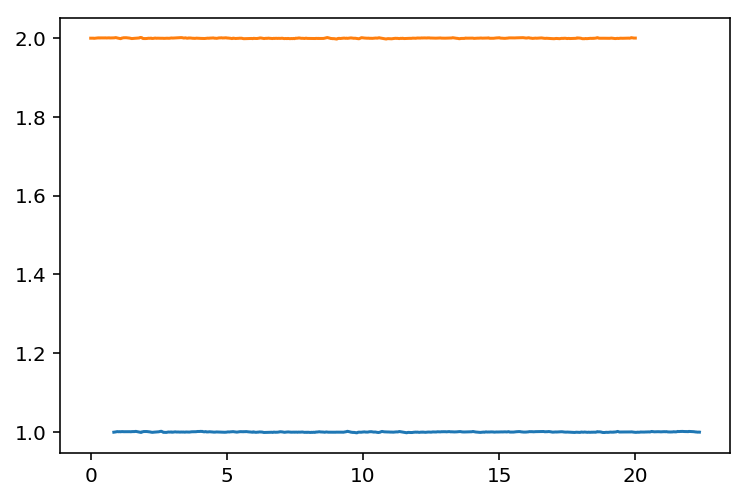

In [3]:
from libra import spitzer_variability

t = np.linspace(0, 20, 1000)
f = spitzer_variability(t)

gp_times, gp_flux = np.loadtxt('../libra/data/spitzer_4.5um_gp.txt', unpack=True)

plt.plot(gp_times, gp_flux + 1)
plt.plot(t, f + 1)

In [4]:
freq, power = np.loadtxt('../libra/data/aigrain2003.csv', delimiter=',', unpack=True)

freq *= u.uHz
power *= (u.W * u.m**-2) **2 * u.Hz**-1


TypeError: ufunc 'multiply' output (typecode 'O') could not be coerced to provided output parameter (typecode 'd') according to the casting rule ''same_kind''

AttributeError: 'numpy.ndarray' object has no attribute 'unit'

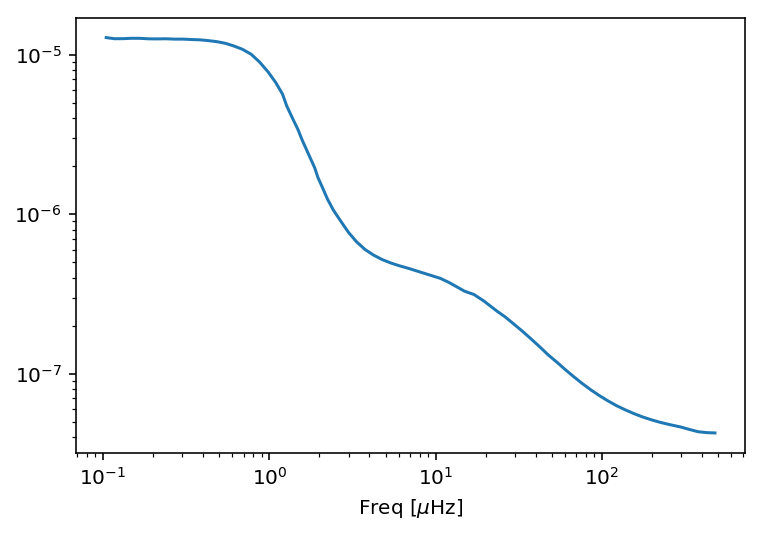

In [5]:
plt.loglog(freq, power)
plt.xlabel('Freq [$\mu$Hz]')
plt.ylabel('Power [{0}]'.format(power.unit))

In [ ]:
def tremblay_char_size(logg, teff, z=0):
    """Tremblay 2013 Eqn 15"""
    return 13.5 * (teff - 300 * logg)**1.75 * 10**(0.05 * z) / 10**logg * u.km

def tremblay_decay_time(logg, teff, z=0):
    """Tremblay 2013 Eqn 16"""
    return 2.08 * (teff - 300 * logg)**1.75 * 10**(0.05 * z) / 10**logg * u.s

def trampedach_char_size(logg, teff, z=0):
    """Trampedach 2013 Eqn 19"""
    return 10**(1.3210 * np.log10(teff) - 1.0970 * logg + 0.0306) * u.Mm

def trampedach_intensity(logg, teff, z=0):
    """Trampedach 2013 Eqn 21"""
    return (54.98 * np.log10(teff) - 4.80 * logg - 169.00) / 100

logg = 4.5
teffs = np.linspace(2500, 6000)
tremblay_sizes = tremblay_char_size(logg, teffs)
tremblay_decays = tremblay_decay_time(logg, teffs)
trampedach_sizes = trampedach_char_size(logg, teffs)
trampedach_int = trampedach_intensity(logg, teffs)

fig, ax = plt.subplots(3, 1, figsize=(4, 6), sharex=True)
ax[0].plot(teffs, tremblay_sizes, label='Tremblay Eqn 15')
ax[0].plot(teffs, trampedach_sizes.to(u.km), label='Trampedach Eqn 19')

ax[1].plot(teffs, tremblay_decays, label='Tremblay Eqn 16')
ax[0].set(ylabel='Characteristic size [km]')
ax[1].set(ylabel='Decay time [s]')

ax[2].set(ylabel='Intensity contrast')

ax[2].plot(teffs, trampedach_int, label='Trampedach Eqn 21', c='C1')
ax[-1].set(xlabel='$T_\mathrm{eff}$')

ax[0].scatter([2800], [80], label='Ludwig 02', color='C2')

ax[2].scatter([2800], [0.011], label='Ludwig 02', color='C2')

for axis in ax: 
    axis.grid()
    axis.legend(loc='upper left', fontsize=10)
fig.tight_layout()
fig.savefig('granulation.pdf', bbox_inches='tight')

<Container object of 3 artists>

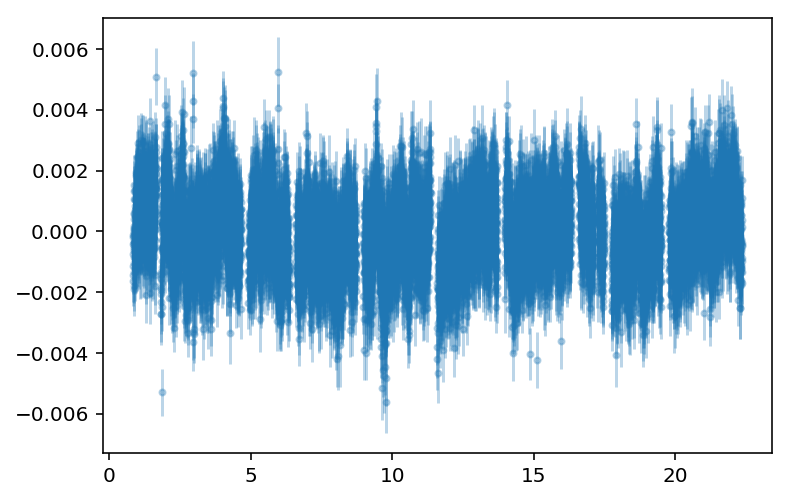

In [6]:
spitzer_time, spitzer_flux, spitzer_err, _ = np.loadtxt('../libra/data/T1_Spitzer.txt', 
                                              unpack=True, delimiter=',')

plt.errorbar(spitzer_time, spitzer_flux, spitzer_err, fmt='.', alpha=0.3)

0.48931000009361014

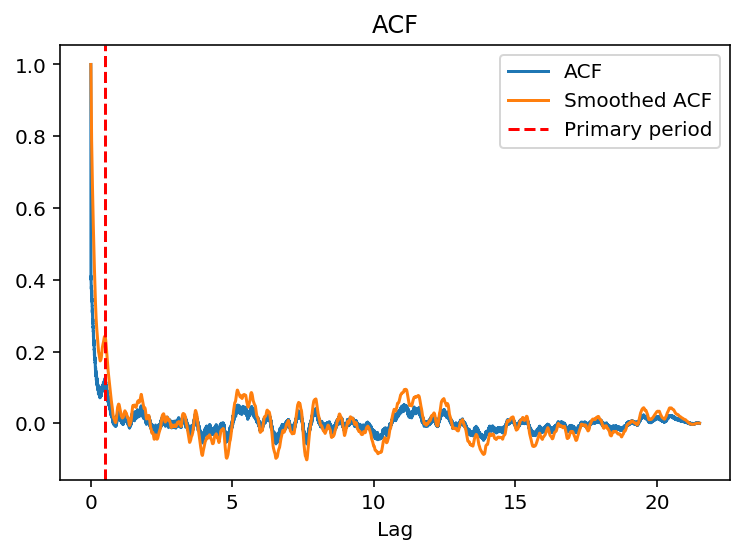

In [7]:
from interpacf import interpolated_acf, dominant_period

lag, acf = interpolated_acf(spitzer_time, spitzer_flux)
dominant_period(lag, acf, plot=True)

In [8]:
from gatspy import periodic

upper_lim = 8
model = periodic.LombScargleFast(fit_period=True)
model.optimizer.period_range = (0.2, upper_lim)
model.fit(spitzer_time, spitzer_flux, spitzer_err);
model.best_period

Finding optimal frequency:
 - Estimated peak width = 0.292
 - Using 5 steps per peak; omega_step = 0.0584
 - User-specified period range:  0.2 to 8
 - Computing periods at 526 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


3.9987307311959763

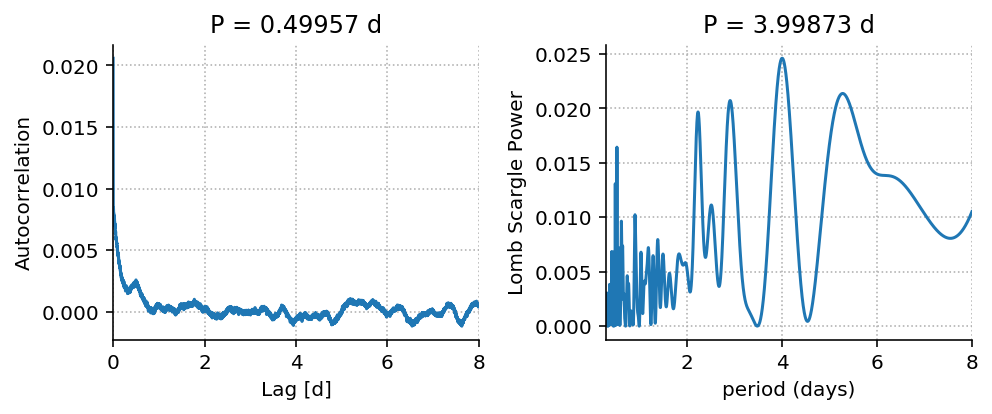

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
#ax[0].semilogy(lag, acf)
ax[0].plot(lag, acf)
ax[0].set_xlim([0, upper_lim])
#ax[0].set_ylim([1e-5, 1e-2])
ax[0].set_xlabel('Lag [d]')
ax[0].set_ylabel('Autocorrelation')

lagrange = ((lag > 0.4) & (lag < 0.6))
peak_acf = lag[lagrange][np.argmax(acf[lagrange])]
ax[0].set_title("P = {0:.5f} d".format(peak_acf))

# Compute the scores on a grid of periods
periods = np.linspace(0.2, upper_lim, 10000)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)
ax[1].set_title("P = {0:.5f} d".format(model.best_period))
ax[1].plot(periods, scores)
ax[1].set(xlabel='period (days)', ylabel='Lomb Scargle Power',
          xlim=(0.3, upper_lim))

for axis in ax: 
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.grid(ls=':')
    
fig.tight_layout()
fig.savefig('quasiperiodic.pdf')

(0, 8)

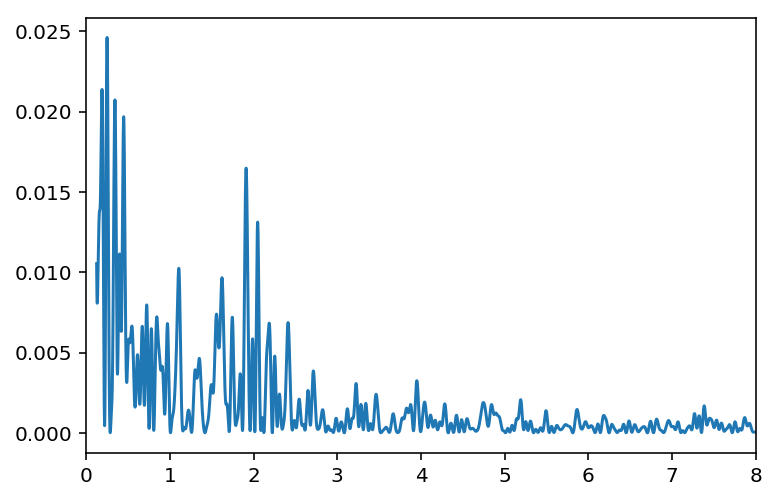

In [13]:

from _statistics import false_alarm_probability
from astropy.stats import LombScargle
ls = LombScargle(spitzer_time * u.day, spitzer_flux, spitzer_err)

frequency, power = ls.autopower(minimum_frequency=1/(8*u.day), maximum_frequency=1/(0.01*u.day), 
                                         samples_per_peak=100)

# ls = LombScargle(spitzer_time, spitzer_flux, spitzer_err)

# frequency, power = ls.autopower(minimum_frequency=1/(8), maximum_frequency=1/(0.01), 
#                                          samples_per_peak=100)
# print(ls.false_alarm_probability(power.max()))


plt.plot(frequency, power)
plt.xlim([0, 8])

In [19]:
false_alarm_probability(power.max(), frequency[np.argmax(power)], ls.t, ls.y, ls.dy)

1.5579804501394403e-67

In [16]:
false_alarm_probability?

Signature: false_alarm_probability(Z, fmax, t, y, dy, normalization='standard', method='baluev', method_kwds=None)
Docstring:
Compute the approximate false alarm probability for periodogram peaks Z

This gives an estimate of the false alarm probability for the largest value
in a periodogram, based on the null hypothesis of non-varying data with
Gaussian noise. The true probability cannot be computed analytically, so
each method available here is an approximation to the true value.

Parameters
----------
Z : array-like
    The periodogram value.
fmax : float
    The maximum frequency of the periodogram.
t, y, dy : array-like
    The data times, values, and errors.
normalization : {'standard', 'model', 'log', 'psd'}, optional
    The periodogram normalization.
method : {'baluev', 'davies', 'naive', 'bootstrap'}, optional
    The approximation method to use.
method_kwds : dict, optional
    Additional method-specific keywords.

Returns
-------
false_alarm_probability : np.ndarray
    The 